In [22]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import RMSprop

warnings.filterwarnings("ignore")

# Scores

In [5]:
def calculate_smape(actual, predicted, epsilon=1e-8):
    absolute_diff = np.abs(actual - predicted)
    sum_absolute = np.abs(actual) + np.abs(predicted)
    smape = np.mean(200 * (absolute_diff / (sum_absolute + epsilon)))
    
    return smape


def calculate_mase(train_series, actuals, forecasts, m):
    masep = np.mean(np.abs(train_series[m:] - train_series[:-m]))
    mean_absolute_forecast_error = np.mean(np.abs(actuals - forecasts))
    
    return mean_absolute_forecast_error / masep


def calculate_owa(smape_method, mase_method, smape_naive2, mase_naive2):
    relative_smape = smape_method / smape_naive2
    relative_mase = mase_method / mase_naive2
    return (relative_smape + relative_mase) / 2

# Seasonality Functions

In [6]:
def seasonality_test(series, ppy):
    """
    Determines whether a time series is seasonal using a 90% autocorrelation test.
    
    :param series: The time series data.
    :param ppy: Periods per year (seasonality frequency).
    :return: Boolean indicating whether the series is seasonal.
    """
    tcrit = 1.645  # 90% critical value for seasonality test
    
    # Ensure we have enough data points for the test
    if len(series) < 3 * ppy:
        return False  
    
    # Calculate the autocorrelation function (acf) up to ppy lags
    acf_values = acf(series, nlags=ppy, fft=False)
    
    # Exclude the zero lag and consider only the first `ppy` lags
    acf_values = acf_values[1:(ppy + 1)]
    
    # Calculate the cumulative limit
    cumulative_sum = np.cumsum([1] + list(2 * np.square(acf_values[:-1])))  
    clim = tcrit / np.sqrt(len(series)) * np.sqrt(cumulative_sum)
    
    # Ensure `ppy` is within bounds of the acf_values and clim arrays
    if ppy > len(acf_values) or ppy > len(clim):
        return False  # Out of bounds, cannot determine seasonality
    
    # Perform the seasonality test
    test_seasonal = (abs(acf_values[ppy - 1]) > clim[ppy - 1])  
    
    return test_seasonal if not pd.isna(test_seasonal) else False


def seasonal_adjustment(series, m, forecast_horizon):
    """
    Applies multiplicative seasonal adjustment to a time series if it's seasonal.

    :param series: The input time series data as a pandas Series.
    :param m: Seasonality frequency (periods per year).
    :param forecast_horizon: The forecast horizon for future predictions.
    :return: seasonally_adjusted_series, seasonal_indices, is_seasonal
    """
    is_seasonal = seasonality_test(series, m)

    if is_seasonal:
        decomposition = seasonal_decompose(series, model='multiplicative', period=m)
        seasonal = decomposition.seasonal
        seasonally_adjusted = series / seasonal

        # Get the seasonal indices over the forecast horizon
        seasonal_indices = np.tile(seasonal[-m:], forecast_horizon)[:forecast_horizon]
    else:
        seasonally_adjusted = series
        seasonal_indices = np.ones(forecast_horizon)  # No adjustment needed
    
    return seasonally_adjusted, seasonal_indices, is_seasonal


def detrend_series(series):
    """
    Removes the linear trend from a time series using a simple linear regression approach.

    :param series: The input time series data as a pandas Series or numpy array.
    :return: A tuple containing the detrended series and a dictionary with the coefficients {'a': slope, 'b': intercept}.
    """
    
    x = np.arange(len(series))
    a, b = np.polyfit(x, series, 1)
    detrended_series = series - (a * x + b)
    return detrended_series, {'a': a, 'b': b}


# Read - Process Dataset

In [7]:
m4_info = pd.read_csv("../archive/m4_info.csv")
m4_info = m4_info.set_index("M4id").T.to_dict("dict")
m4_info["Y1"]

datasets = {}
types = ["Daily", "Hourly", "Monthly", "Quarterly", "Weekly", "Yearly"]

for dataset in ["train", "test"]:
    datasets[dataset] = {}
    for series_type in tqdm(types):
        df = pd.read_csv(f"../archive/{series_type}-{dataset}.csv")
        df.insert(0, series_type, df["V1"])
        df = df.shift(-1, axis=1)
        df = df.set_index(series_type).T.to_dict("list")
        df = {k: np.array(v)[:-1] for k, v in df.items()}
        df = {k: v[: np.where(~np.isnan(v))[0][-1] + 1] for k, v in df.items()}
        datasets[dataset][series_type] = df

100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


# Methods Functions

## Naïve 1

A random walk model that assumes future values will be the same as the last known observation.

$$
\hat{y}_{t+h} = y_t
$$


where ${y}$ is the last observed value at time $t$.

In [8]:
def naive_1(train_series, horizon):

    return [train_series[-1]] * horizon

## Naïve Seasonal (Naïve S)

Forecasts are equal to the last known observation from the same period in the seasonal cycle.

$$
\hat{y}_{t+h} = y_{t+h - mk}
$$

where $m$ is the seasonal period, and $k$ represents the complete cycles.

In [9]:
def naive_s(train_series, horizon, m):
    # Forecasts are equal to the last known observation of the same period
    forecast_all = np.concatenate([train_series, np.zeros(horizon)])
    for i in range(horizon):
        forecast_all[len(train_series) + i] = forecast_all[len(train_series) - m + i]

    forecast = forecast_all[len(train_series) :]
    return forecast


## Naïve 2

Similar to Naïve 1 but seasonally adjusted using a classical multiplicative decomposition. A 90% autocorrelation test determines whether the data is seasonal.
If seasonality is detected:

$$
\hat{y}_{t+h} = s_{t + (h \mod m)} \cdot y_t
$$

where $s_{t}$ represents the seasonal indices.

Seasonal adjustment is performed using seasonal_adjustment() based on a multiplicative decomposition.

In [10]:
def naive_2(train_series, horizon, m):

    # Apply seasonal adjustment
    s_adjusted, seasonal_indices, is_seasonal = seasonal_adjustment(train_series, m, horizon)
    
    # Use the last seasonally adjusted value for Naïve 2
    forecast = s_adjusted[-1]
    
    # Adjust the forecast by multiplying by the seasonal indices
    forecast_values = forecast * seasonal_indices
    
    return forecast_values

## Simple Exponential Smoothing (SES)

Applies exponential smoothing to the data without assuming a trend. The model gives more weight to recent observations.

$$
\hat{y}_{t+h} = \alpha y_t + (1 - \alpha) \hat{y}_{t-1}
$$

where $\alpha$ is the smoothing parameter.

Used statsmodels' SimpleExpSmoothing.

In [11]:
def ses(train_series, horizon, m):
    # Apply seasonal adjustment
    s_adjusted, seasonal_indices, _ = seasonal_adjustment(train_series, m, horizon)
    
    # Apply SES to seasonally adjusted data
    model = SimpleExpSmoothing(s_adjusted).fit()
    forecast = model.forecast(horizon)
    
    # Adjust forecasts by multiplying by the seasonal indices
    forecast = forecast * seasonal_indices
    
    return forecast

## Holt's Linear Trend

Expands SES to accommodate a linear trend, making it suitable for series with trends.

$$
\hat{y}_{t+h} = l_t + h \cdot b_t
$$

where $l_t$ is the level and $b_t$ is the trend component.

Used ExponentialSmoothing with trend='add'.

In [12]:
def holt_forecast(train_series, horizon, m):
    # Apply the seasonal adjustment using the provided seasonal_adjustment function
    adjusted_series, seasonal_indices, is_seasonal = seasonal_adjustment(
        train_series, m, horizon
    )

    # Apply Holt's Linear Trend Model to the adjusted series
    holt_model = ExponentialSmoothing(
        adjusted_series, trend="add", seasonal=None, initialization_method="estimated"
    ).fit()
    holt_forecast = holt_model.forecast(horizon)

    # Adjust the forecast with the seasonal component if the series is seasonal
    if is_seasonal:
        final_forecast = holt_forecast * seasonal_indices
    else:
        final_forecast = holt_forecast

    return final_forecast

## Damped Trend


Extends Holt's method with a damping factor $\phi$ to smooth the trend over time, preventing over-forecasting.

$$
\hat{y}_{t+h} = l_t + \left(\frac{1 - \phi^h}{1 - \phi}\right) b_t
$$

where $\phi$ is the damping parameter.

Used ExponentialSmoothing with damped_trend=True

In [13]:
def damped(train_series, horizon, m): 
    seasonal = 'multiplicative' if m > 1 else None
    seasonal_periods = m if m > 1 else None

    model = ExponentialSmoothing(
        train_series, 
        trend='add', 
        damped_trend=True, 
        seasonal=seasonal,  
        seasonal_periods=seasonal_periods
    )
    
    fitted_model = model.fit(optimized=True) 
    forecast = fitted_model.forecast(horizon)
    
    return forecast

## Theta Method

Combines two theta lines, $\theta_{1}=0$ (linear regression) and $\theta_{2}=2$ (SES) and takes their average

$$
\hat{y}_{t+h} = \frac{1}{2}\left(\hat{y}_{\theta=0} + \hat{y}_{\theta=2}\right)
$$

Used OLS for linear regression and SimpleExpSmoothing for the SES.

In [14]:
def theta_forecast(train_series, horizon, m):
    adjusted_series, seasonal_indices, is_seasonal = seasonal_adjustment(
        train_series, m, horizon
    )

    n = len(adjusted_series)
    time = np.arange(1, n + 1)

    # Theta line theta_1 = 0: Extrapolation using linear regression
    X = sm.add_constant(time)
    model_lr = sm.OLS(adjusted_series, X).fit()
    trend_forecast = model_lr.predict(
        sm.add_constant(np.arange(n + 1, n + horizon + 1))
    )

    # Theta line theta_2 = 2: Extrapolation using Simple Exponential Smoothing (SES)
    ses_model = SimpleExpSmoothing(
        adjusted_series, initialization_method="estimated"
    ).fit(optimized=True)
    ses_forecast = ses_model.forecast(horizon)

    # Combine the two forecasts with equal weights
    combined_forecast = (trend_forecast + ses_forecast) / 2

    # Adjust the combined forecast with the seasonal component if the series is seasonal
    if is_seasonal:
        final_forecast = combined_forecast * seasonal_indices
    else:
        final_forecast = combined_forecast

    return final_forecast

## Comb Method

A simple arithmetic average of SES, Holt, and Damped methods.

$$
\hat{y}_{t+h}^{Comb} = \frac{\hat{y}_{t+h}^{SES} + \hat{y}_{t+h}^{Holt} + \hat{y}_{t+h}^{Damped}}{3}
$$


In [15]:
def comb(train_series, horizon, m):
    """
    Comb method: An arithmetic average of SES, Holt, and Damped methods.
    
    :param train_series: The training time series data (as pandas Series or numpy array).
    :param horizon: The forecast horizon (number of future periods to predict).
    :param m: Seasonality frequency (periods per year).
    :return: The combined forecast values for the given horizon.
    """
    # Apply SES, Holt, and Damped forecasts
    ses_pred = ses(train_series, horizon, m)
    holt_pred = holt_forecast(train_series, horizon, m)
    damped_pred = damped(train_series, horizon, m)
    
    # Compute the arithmetic average of the three methods
    combined_forecast = (ses_pred + holt_pred + damped_pred) / 3
    
    return combined_forecast


## MLP (Multilayer Perceptron)

A basic neural network model that applies detrending and deseasonalization before forecasting. The MLP captures non-linear patterns and relationships.

Used MLPRegressor from scikit-learn with preprocessing.

In [16]:
def mlp(train_series, horizon, m):
    s_adjusted, seasonal_indices, is_seasonal = seasonal_adjustment(train_series, m, horizon)
    
    detrended_series, trend_params = detrend_series(s_adjusted)

    x_train, y_train = [], []
    for i in range(len(detrended_series) - m):
        x_train.append(detrended_series[i:i + m])
        y_train.append(detrended_series[i + m])

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    mlp = MLPRegressor(hidden_layer_sizes=(m*2,), activation='identity', solver='adam',
                       max_iter=1000, learning_rate='adaptive', learning_rate_init=0.001,
                       random_state=42)
    mlp.fit(x_train, y_train)

    forecast_input = list(detrended_series[-m:])
    forecast = []

    for _ in range(horizon):
        next_forecast = mlp.predict([forecast_input])[0]
        forecast.append(next_forecast)
        
        # Shift input window
        forecast_input = forecast_input[1:] + [next_forecast]

    # Add trend back to the forecast
    forecast_with_trend = [forecast[i] + (trend_params['a'] * (len(train_series) + i) + trend_params['b'])
                           for i in range(horizon)]

    # Adjust by seasonal indices if the series is seasonal
    if is_seasonal:
        forecast_with_trend = np.array(forecast_with_trend) * seasonal_indices

    return forecast_with_trend


## RNN (Recurrent Neural Network)

A recurrent network of a very basic architecture and parameterization. Preprocessing such as detrending and deseasonalization is applied beforehand to facilitate extrapolation.

UtilizeD a basic RNN architecture with preprocessing steps (detrending and deseasonalization) before training the model. The SimpleRNN layer captures temporal patterns, and the Dense layer provides the final forecasted output. The model is trained using the RMSprop optimizer.

In [17]:
def rnn_forecast(train_series, horizon, m):
    """
    Forecasts the given time series using an RNN model after detrending and deseasonalizing.

    :param train_series: The input time series data as a pandas Series or numpy array.
    :param horizon: The forecast horizon (number of future steps to predict).
    :param m: The seasonality period (e.g., 12 for monthly data).
    :return: The final forecasted values as a numpy array.
    """
    # Step 1: Apply seasonal adjustment
    s_adjusted, seasonal_indices, is_seasonal = seasonal_adjustment(
        train_series, m, horizon
    )

    # Step 2: Detrend the seasonally adjusted series
    detrended_series, trend_params = detrend_series(s_adjusted)

    # Step 3: Prepare training data
    x_train, y_train = [], []
    for i in range(len(detrended_series) - m):
        x_train.append(detrended_series[i : i + m])
        y_train.append(detrended_series[i + m])

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Reshape x_train for RNN input: (samples, timesteps, features)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

    # Step 4: Build the RNN model
    model = Sequential(
        [
            SimpleRNN(3, input_shape=(m, 1), activation="linear", use_bias=False),
            Dense(1, use_bias=True, activation="linear"),
        ]
    )

    # Compile the model with RMSprop optimizer
    opt = RMSprop(learning_rate=0.001)
    model.compile(loss="mean_squared_error", optimizer=opt)

    # Fit the model to the training data
    model.fit(x_train, y_train, epochs=50, batch_size=1, verbose=0)

    # Step 5: Forecast using the trained RNN model
    forecast_input = detrended_series[-m:].reshape((1, m, 1))
    forecast = []

    for _ in range(horizon):
        next_forecast = model.predict(forecast_input, verbose=0)[0, 0]
        forecast.append(next_forecast)

        # Shift input window
        forecast_input = np.append(
            forecast_input[:, 1:, :], [[[next_forecast]]], axis=1
        )

    # Step 6: Add trend back to the forecast
    forecast_with_trend = [
        forecast[i] + (trend_params["a"] * (len(train_series) + i) + trend_params["b"])
        for i in range(horizon)
    ]

    # Step 7: Adjust by seasonal indices if the series is seasonal
    if is_seasonal:
        forecast_with_trend = np.array(forecast_with_trend) * seasonal_indices

    return forecast_with_trend

# Methods Evaluation

In [18]:
def adjust_precision(df, with_owa=False):
    df['Time (s)'] = df['Time (s)'].round(5)
    df['sMAPE'] = df['sMAPE'].round(3)
    df['MASE'] = df['MASE'].round(3)
    if with_owa:
        df['OWA'] = df['OWA'].round(3)
    return df

Evaluation Process: 

The pipeline evaluates each forecasting method across multiple frequencies, measuring performance using sMAPE and MASE metrics, comparing them to a Naïve 2 benchmark for the final OWA metric.

Execution time is monitored for each method, both overall and for each frequency.

Results are collected and structured into two main DataFrames: one for overall metrics and another for frequency-specific metrics.

In [24]:

method_name_func = [
    ('Naïve 1', naive_1),
    ('Naive S', naive_s),
    ('Naïve 2', naive_2),
    ('SES', ses),
    ('Holt', holt_forecast),
    ('Damped', damped),
    ('Comb', comb),
    ('Theta', theta_forecast),
    ('RNN', rnn_forecast),
    ('MLP', mlp),
]


smape_naive2 = 13.564 
mase_naive2 = 1.912

method_to_overall_res = {}
method_to_freq_res = {}

for method_name, method_func in method_name_func:
    print(f"Evaluating Method: {method_name}...")

    method_smape_scores = []
    method_mase_scores = []
    exec_time = 0
    series_types_res = {}

    for series_type in types:
        type_smape_scores = []
        type_mase_scores = []
        type_exec_time = 0
        type_predictions = []

        for series, train_values in tqdm(datasets["train"][series_type].items(), desc=f"Processing {series_type} Series"):

            frequency = m4_info[series]["Frequency"]
            horizon = m4_info[series]["Horizon"]
            true_values = datasets["test"][series_type][series]

            method_extra_args = {}
            if method_name != 'Naïve 1': 
                method_extra_args['m'] = frequency

            s_time = time.time()
            prediction = method_func(train_values, horizon, **method_extra_args)
            total_time = time.time() - s_time

            smape = calculate_smape(true_values, prediction)
            mase = calculate_mase(train_values, true_values, prediction, frequency)

            exec_time += total_time
            method_smape_scores.append(smape)
            method_mase_scores.append(mase)
        
            type_exec_time += total_time
            type_smape_scores.append(smape)
            type_mase_scores.append(mase)
            type_predictions.append(prediction)
            
            break

        
        series_types_res[series_type] = {
            'sMAPE': np.mean(type_smape_scores),
            'MASE': np.mean(type_mase_scores),
            'Time (s)': type_exec_time,
            'Prediction': type_predictions,
        }

    overall_results = {
        'sMAPE': np.mean(method_smape_scores),
        'MASE': np.mean(method_mase_scores),
        'OWA': calculate_owa(np.mean(method_smape_scores), np.mean(method_mase_scores), smape_naive2, mase_naive2),
        'Time (s)': exec_time,
    }

    method_to_freq_res[method_name] = series_types_res
    method_to_overall_res[method_name] = overall_results
    print()
    
results_df = pd.DataFrame.from_dict(method_to_overall_res, orient='index')
results_df = adjust_precision(results_df, with_owa=True)
display(results_df)

method_to_freq_res_list = []
for method, freq_data in method_to_freq_res.items():
    for period, metrics in freq_data.items():
        metrics['Method'] = method
        metrics['Period'] = period
        method_to_freq_res_list.append(metrics)

method_period_df = pd.DataFrame(method_to_freq_res_list)
method_period_df = adjust_precision(method_period_df)
display(method_period_df)

Evaluating Method: Naïve 1...


Processing Yearly Series:   0%|          | 0/23000 [00:00<?, ?it/s]



Evaluating Method: Naive S...


Processing Yearly Series:   0%|          | 0/23000 [00:00<?, ?it/s]



Evaluating Method: Naïve 2...


Processing Yearly Series:   0%|          | 0/23000 [00:00<?, ?it/s]



Evaluating Method: SES...


Processing Yearly Series:   0%|          | 0/23000 [00:00<?, ?it/s]



Evaluating Method: Holt...


Processing Yearly Series:   0%|          | 0/23000 [00:00<?, ?it/s]



Evaluating Method: Damped...


Processing Yearly Series:   0%|          | 0/23000 [00:00<?, ?it/s]



Evaluating Method: Comb...


Processing Yearly Series:   0%|          | 0/23000 [00:00<?, ?it/s]



Evaluating Method: Theta...


Processing Yearly Series:   0%|          | 0/23000 [00:00<?, ?it/s]



Evaluating Method: RNN...


Processing Yearly Series:   0%|          | 0/23000 [00:00<?, ?it/s]



Evaluating Method: MLP...


Processing Yearly Series:   0%|          | 0/23000 [00:00<?, ?it/s]

,sMAPE,MASE,OWA,Time (s)
Naïve 1,9.752,4.525,1.543,0.00004
Naive S,5.172,3.966,1.228,0.00016
Naïve 2,4.940,3.926,1.209,0.00521
SES,4.872,3.914,1.203,0.01978
Holt,5.576,4.365,1.347,0.08177
Damped,4.951,4.199,1.281,0.22963
Comb,4.942,4.118,1.259,0.31961
Theta,7.938,19.198,5.313,0.01590
RNN,5.186,4.045,1.249,60.95362
MLP,4.928,3.868,1.193,0.67324


,sMAPE,MASE,Time (s),Prediction,Method,Period
0,1.564,7.202,0.00002,"[[2029.7, 2029.7, 2029.7, 2029.7, 2029.7, 2029...",Naïve 1,Daily
1,20.166,3.104,0.00001,"[[684.0, 684.0, 684.0, 684.0, 684.0, 684.0, 68...",Naïve 1,Hourly
2,28.370,2.281,0.00001,"[[6890.0, 6890.0, 6890.0, 6890.0, 6890.0, 6890...",Naïve 1,Monthly
3,2.377,0.528,0.00000,"[[6818.1667355648, 6818.1667355648, 6818.16673...",Naïve 1,Quarterly
4,2.057,11.460,0.00001,"[[35397.16, 35397.16, 35397.16, 35397.16, 3539...",Naïve 1,Weekly
5,3.980,2.577,0.00000,"[[7261.1, 7261.1, 7261.1, 7261.1, 7261.1, 7261...",Naïve 1,Yearly
6,1.564,7.202,0.00006,"[[2029.7, 2029.7, 2029.7, 2029.7, 2029.7, 2029...",Naive S,Daily
7,5.263,0.827,0.00002,"[[691.0, 618.0, 563.0, 529.0, 504.0, 489.0, 48...",Naive S,Hourly
8,15.465,1.132,0.00001,"[[9370.0, 7980.0, 6050.0, 5640.0, 6220.0, 5740...",Naive S,Monthly
9,2.702,0.599,0.00003,"[[6702.855568509, 6636.5164505456, 6766.947130...",Naive S,Quarterly


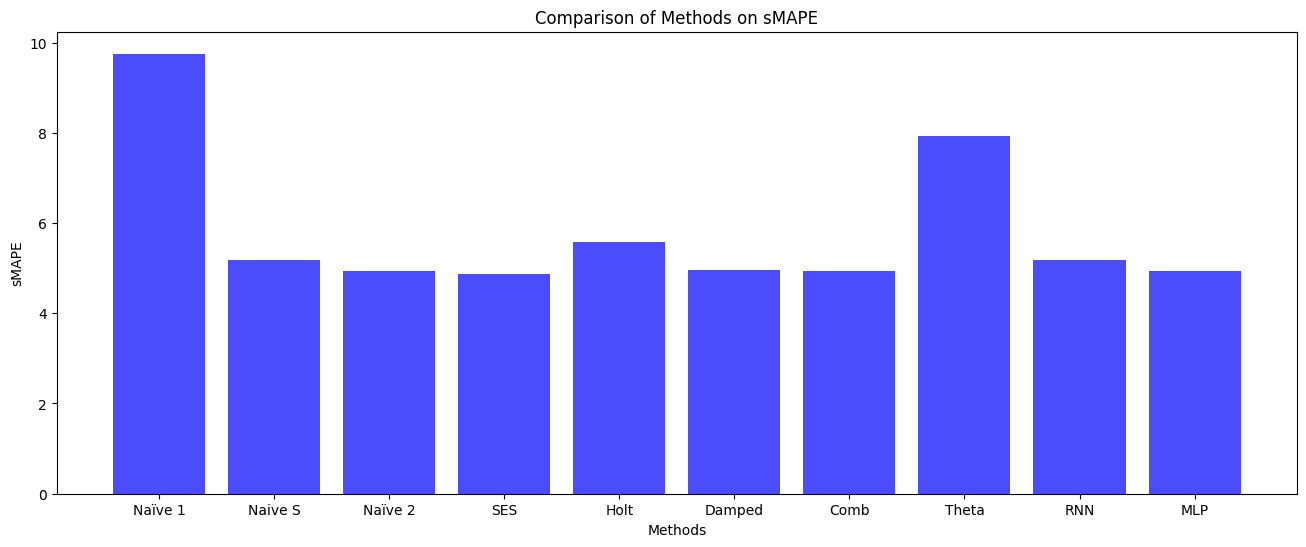

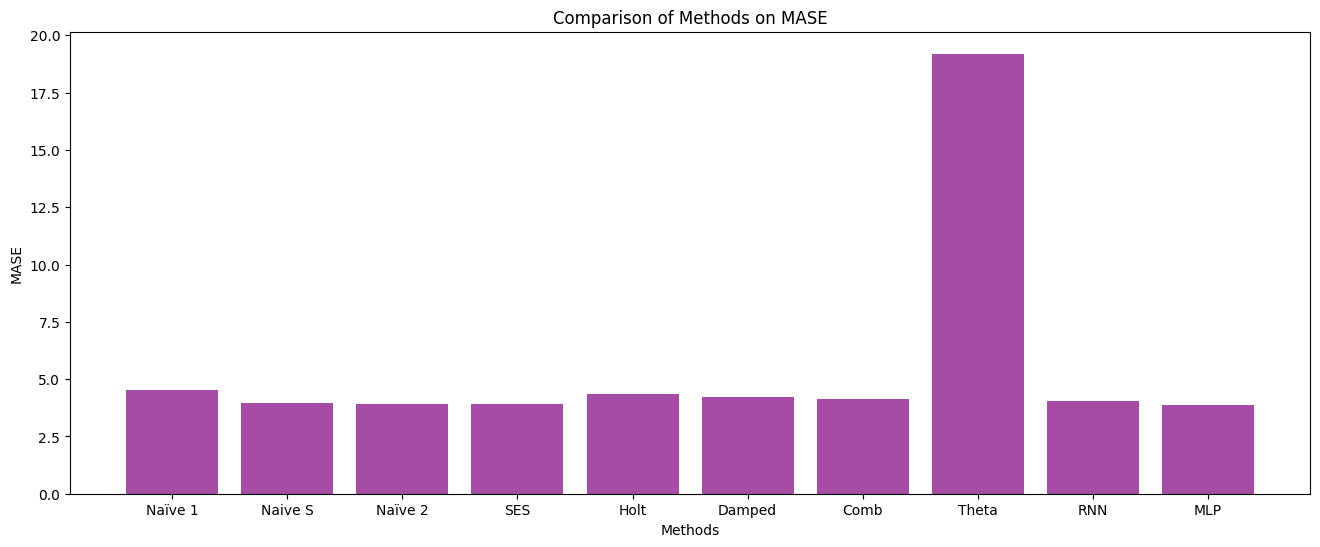

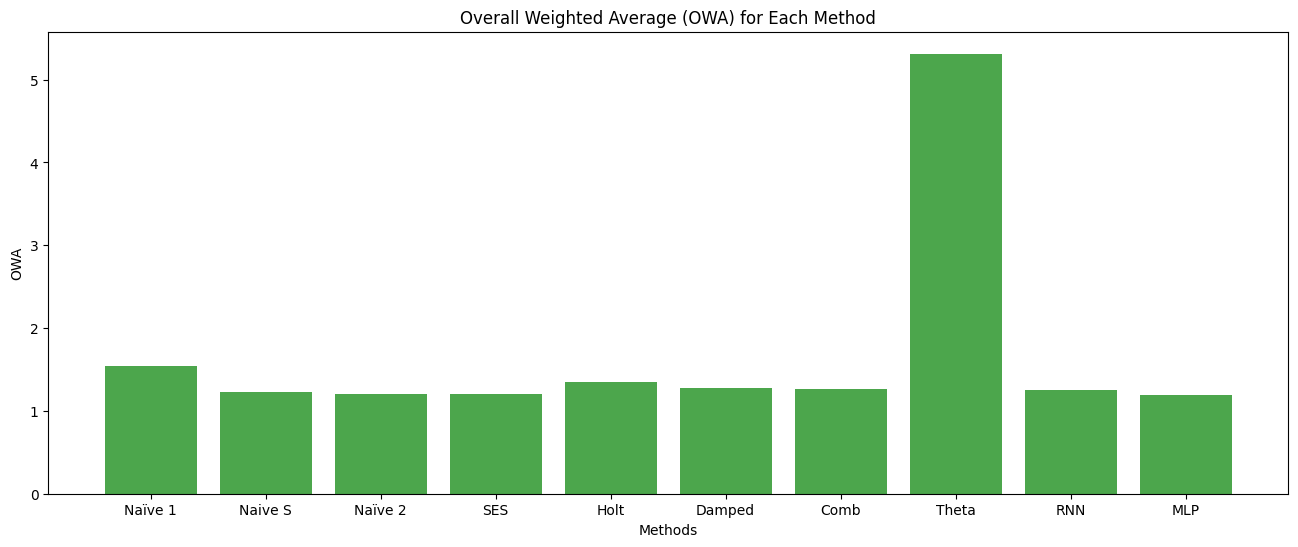

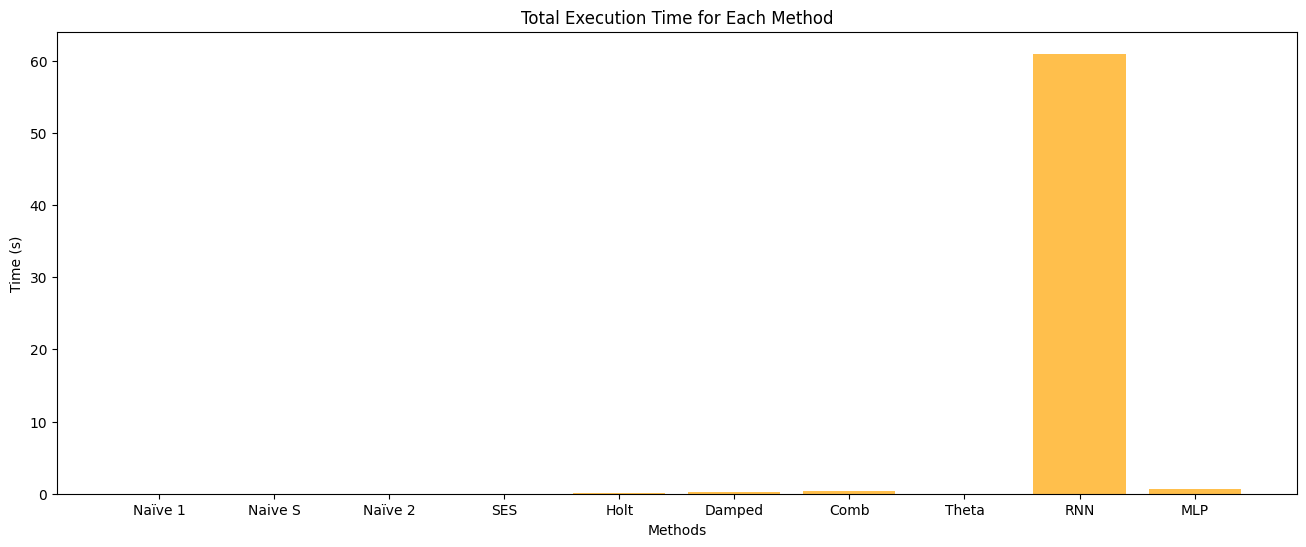

In [25]:
methods_names = []
methods_smapes = []
methods_mases = []
methods_times = [] 
methods_owas = []

for method, results in method_to_overall_res.items():
    methods_names.append(method)
    methods_smapes.append(results['sMAPE'])
    methods_mases.append(results['MASE'])
    methods_times.append(results['Time (s)'])
    methods_owas.append(results['OWA'])

results_df = pd.DataFrame.from_dict(method_to_overall_res, orient='index')
figsize = (16,6)

plt.figure(figsize=figsize)
plt.bar(methods_names, methods_smapes, color='b', alpha=0.7)
plt.xlabel('Methods')
plt.ylabel('sMAPE')
plt.title('Comparison of Methods on sMAPE')
plt.show()

plt.figure(figsize=figsize)
plt.bar(methods_names, methods_mases, color='purple', alpha=0.7)
plt.xlabel('Methods')
plt.ylabel('MASE')
plt.title('Comparison of Methods on MASE')
plt.show()

plt.figure(figsize=figsize)
plt.bar(methods_names, methods_owas, color='green', alpha=0.7)
plt.xlabel('Methods')
plt.ylabel('OWA')
plt.title('Overall Weighted Average (OWA) for Each Method')
plt.show()

plt.figure(figsize=figsize)
plt.bar(methods_names, methods_times, color='orange', alpha=0.7)
plt.xlabel('Methods')
plt.ylabel('Time (s)')
plt.title('Total Execution Time for Each Method')
plt.show()

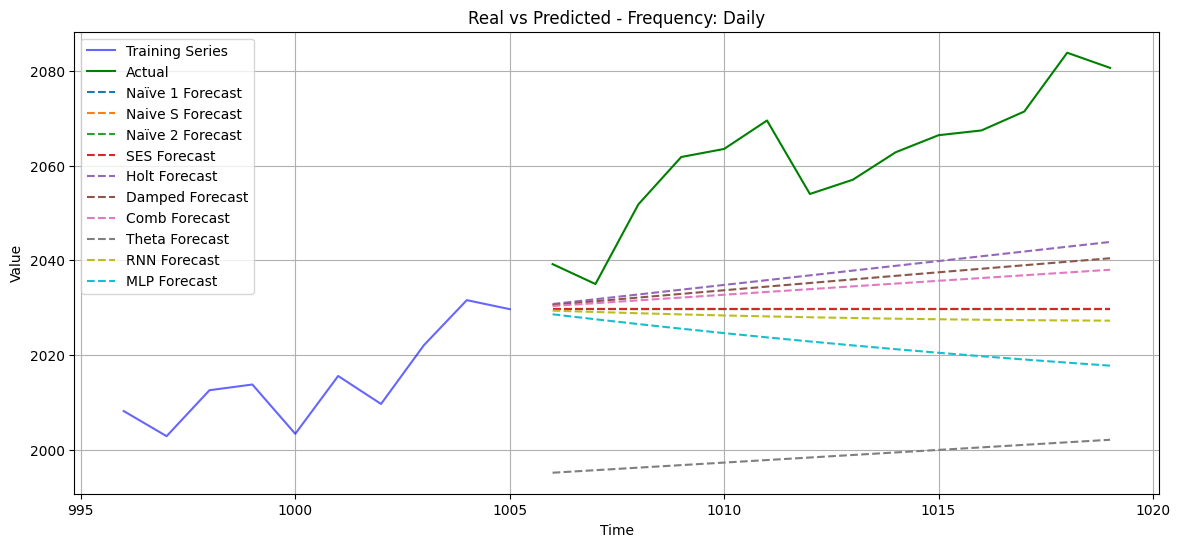

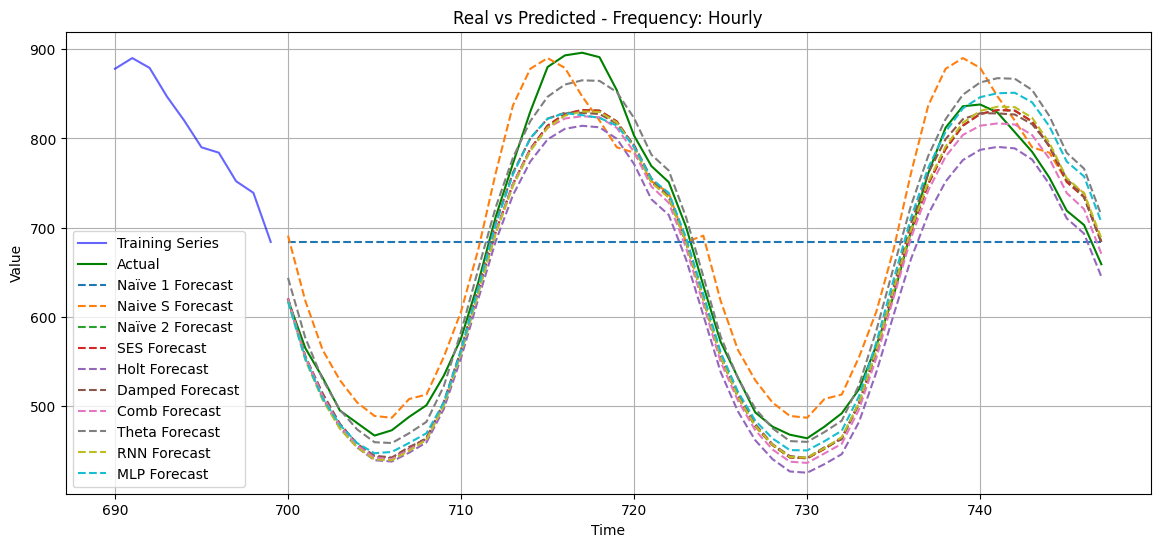

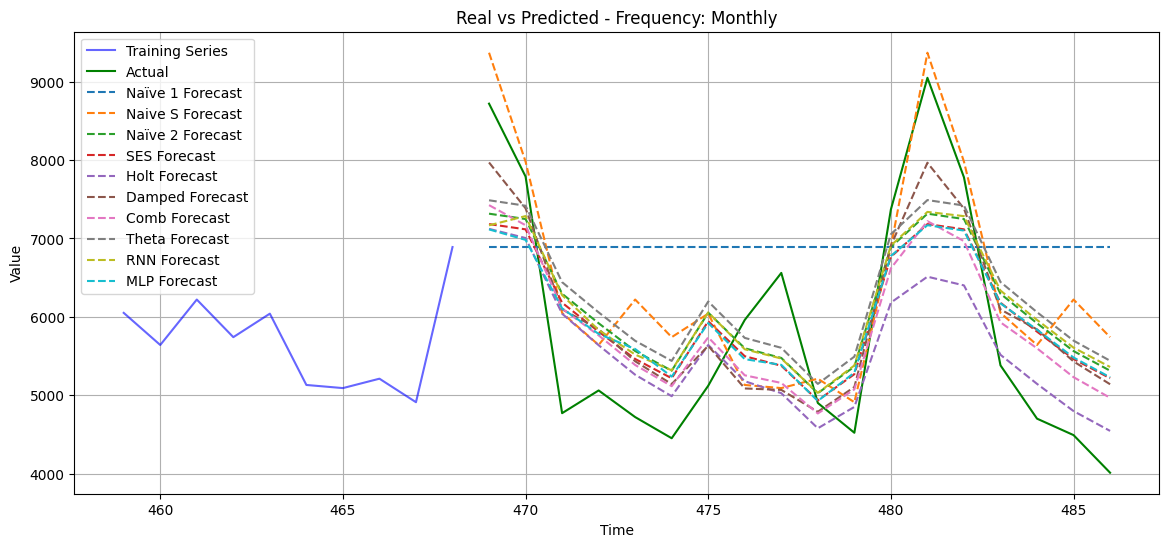

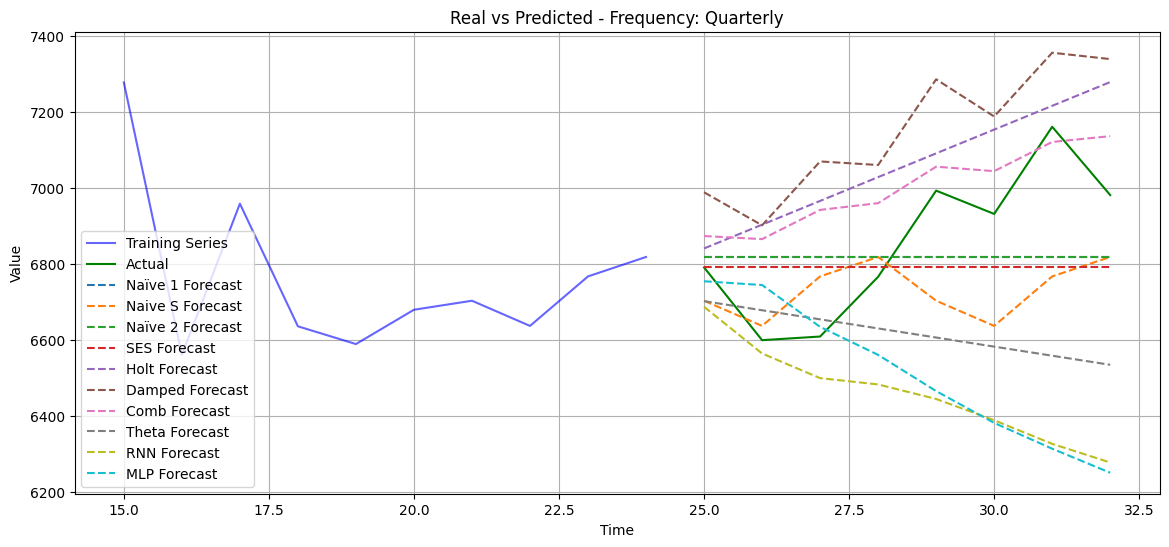

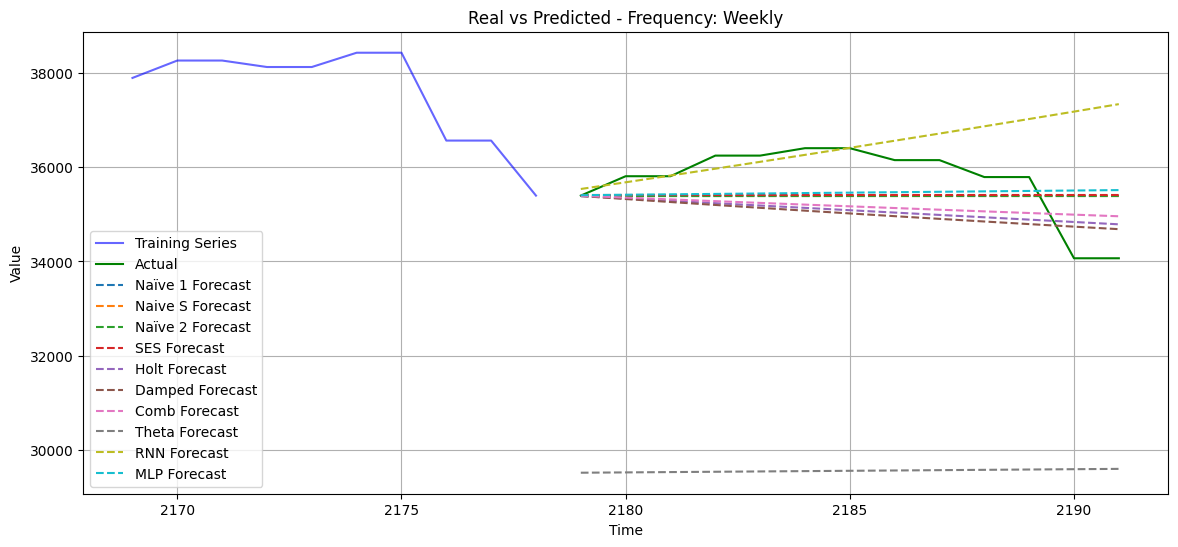

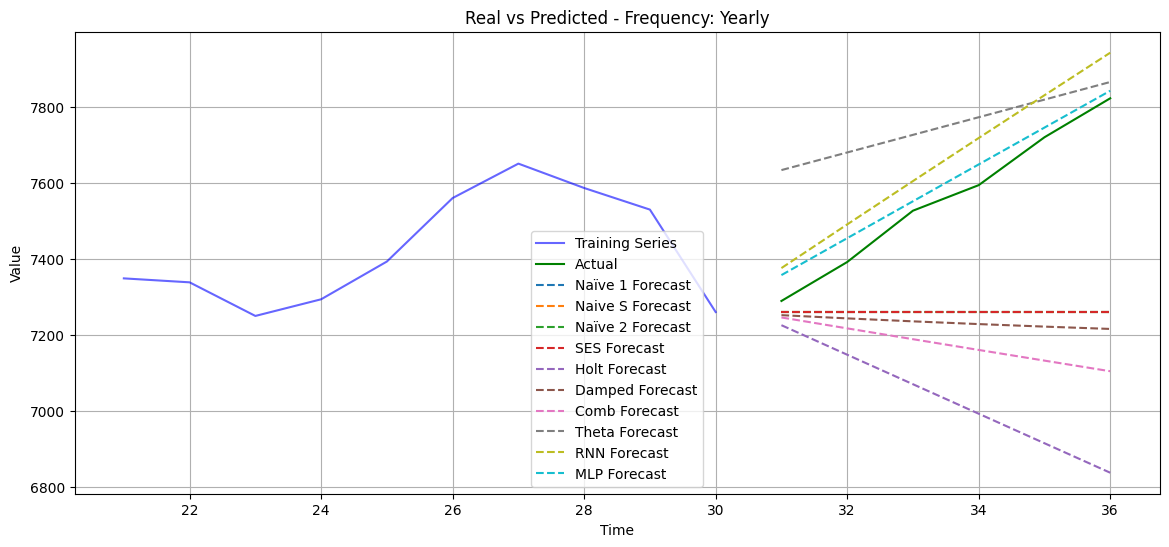

In [26]:
# Plot one series (train, actual, forecast) per period
final_train_series = 10
for series_type in types:
    train_series = list(datasets["train"][series_type].values())[0]
    y_true = list(datasets["test"][series_type].values())[0]

    plt.figure(figsize=(14, 6))
    plt.plot(range(len(train_series) - final_train_series, len(train_series)), train_series[-final_train_series:], label='Training Series', color='blue', alpha=0.6)
    
    plt.plot(range(len(train_series), len(train_series) + len(y_true)), y_true, label='Actual', color='green')
    
    for method_name, freq_results in method_to_freq_res.items():
        y_pred = freq_results[series_type]['Prediction'][0]
        plt.plot(range(len(train_series), len(train_series) + len(y_pred)), y_pred, label=f'{method_name} Forecast', linestyle='dashed')

    plt.title(f'Real vs Predicted - Frequency: {series_type}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()